In [1]:
import os

%pwd

'c:\\09_AHFID\\via-cervix-ai\\notebook'

In [2]:
os.chdir("../")
%pwd

'c:\\09_AHFID\\via-cervix-ai'

### Import and setup

In [3]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Enhanced evaluation with statistical rigor for medical AI

# Paths
RESULTS_DIR = Path("artifacts/training_runs")
EVAL_LABELS = RESULTS_DIR / "eval_labels.npy"
EVAL_PROBS  = RESULTS_DIR / "eval_probs.npy"

CLASS_NAMES = ["Negative", "Positive", "Suspicious cancer"]

# Load data
labels = np.load(EVAL_LABELS)  # shape N
probs  = np.load(EVAL_PROBS)   # shape N x 3
print(f"Loaded {len(labels)} labels and {probs.shape[0]} prediction probabilities")

Loaded 38 labels and 38 prediction probabilities


### Calculate confidence intervals for metrics with bootstrap

In [4]:
def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, confidence_level=0.95):
    """Calculate confidence intervals for metrics using bootstrap"""
    scores = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = resample(range(n_samples), n_samples=n_samples, random_state=None)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices] if y_pred.ndim == 1 else y_pred[indices]
        
        try:
            score = metric_func(y_true_boot, y_pred_boot)
            scores.append(score)
        except:
            continue
    
    scores = np.array(scores)
    alpha = 1 - confidence_level
    lower = np.percentile(scores, (alpha/2) * 100)
    upper = np.percentile(scores, (1 - alpha/2) * 100)
    mean_score = np.mean(scores)
    
    return mean_score, lower, upper

### basic classification report and confusion matrix

In [5]:
# Basic classification report with confidence intervals
preds = np.argmax(probs, axis=1)
report = classification_report(labels, preds, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
cm = confusion_matrix(labels, preds)

print("Confusion Matrix:")
print(pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES))

Confusion Matrix:
                   Negative  Positive  Suspicious cancer
Negative                  8         2                  9
Positive                  4         1                 10
Suspicious cancer         0         0                  4


### sensitivity and specificity per class

In [6]:
# Enhanced sensitivity/specificity with confidence intervals
def sensitivity_specificity_ci(y_true, y_pred, n_bootstrap=1000):
    """Calculate sensitivity and specificity with confidence intervals for each class"""
    results = {}
    
    for i, class_name in enumerate(CLASS_NAMES):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        
        def sensitivity_func(yt, yp):
            cm_temp = confusion_matrix(yt, yp, labels=[0, 1])
            if len(cm_temp) < 2:
                return 0.0
            tp = cm_temp[1, 1]
            fn = cm_temp[1, 0]
            return tp / (tp + fn + 1e-8)
        
        def specificity_func(yt, yp):
            cm_temp = confusion_matrix(yt, yp, labels=[0, 1])
            if len(cm_temp) < 2:
                return 0.0
            tn = cm_temp[0, 0]
            fp = cm_temp[0, 1]
            return tn / (tn + fp + 1e-8)
        
        sens_mean, sens_low, sens_high = bootstrap_metric(y_true_binary, y_pred_binary, sensitivity_func)
        spec_mean, spec_low, spec_high = bootstrap_metric(y_true_binary, y_pred_binary, specificity_func)
        
        results[class_name] = {
            'sensitivity': (sens_mean, sens_low, sens_high),
            'specificity': (spec_mean, spec_low, spec_high)
        }
        
        print(f"{class_name}:")
        print(f"  Sensitivity: {sens_mean:.3f} [{sens_low:.3f}, {sens_high:.3f}]")
        print(f"  Specificity: {spec_mean:.3f} [{spec_low:.3f}, {spec_high:.3f}]")
    
    return results

sens_spec_results = sensitivity_specificity_ci(labels, preds)


Negative:
  Sensitivity: 0.422 [0.211, 0.647]
  Specificity: 0.784 [0.579, 0.950]
Positive:
  Sensitivity: 0.069 [0.000, 0.214]
  Specificity: 0.913 [0.778, 1.000]
Suspicious cancer:
  Sensitivity: 0.986 [1.000, 1.000]
  Specificity: 0.440 [0.270, 0.611]


### ROC AUC per class (one-vs-rest)

Negative AUC: 0.704 [0.521, 0.865]
Positive AUC: 0.465 [0.268, 0.667]
Suspicious cancer AUC: 0.749 [0.486, 1.000]


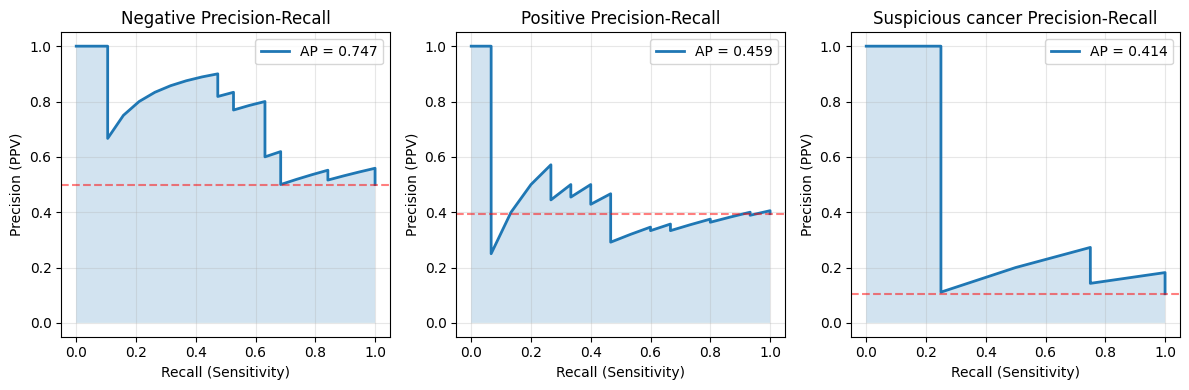

In [7]:
# ROC AUC with confidence intervals
def compute_auc_ci(y_true, y_score, n_bootstrap=1000):
    """Compute AUC with confidence intervals"""
    def auc_func(yt, ys):
        if len(np.unique(yt)) < 2:
            return 0.5
        fpr, tpr, _ = roc_curve(yt, ys)
        return auc(fpr, tpr)
    
    return bootstrap_metric(y_true, y_score, auc_func, n_bootstrap)

auc_results = {}
for i, cname in enumerate(CLASS_NAMES):
    y_true_binary = (labels == i).astype(int)
    y_score = probs[:, i]
    
    auc_mean, auc_low, auc_high = compute_auc_ci(y_true_binary, y_score)
    auc_results[cname] = (auc_mean, auc_low, auc_high)
    
    print(f"{cname} AUC: {auc_mean:.3f} [{auc_low:.3f}, {auc_high:.3f}]")

# Precision-Recall curves (often more informative for medical applications)
plt.figure(figsize=(12, 4))

for i, cname in enumerate(CLASS_NAMES):
    plt.subplot(1, 3, i+1)
    y_true_binary = (labels == i).astype(int)
    y_score = probs[:, i]
    
    precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
    ap_score = average_precision_score(y_true_binary, y_score)
    
    plt.plot(recall, precision, lw=2, label=f'AP = {ap_score:.3f}')
    plt.fill_between(recall, precision, alpha=0.2)
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.title(f'{cname} Precision-Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add baseline (prevalence)
    prevalence = np.mean(y_true_binary)
    plt.axhline(y=prevalence, color='r', linestyle='--', alpha=0.5, label=f'Baseline = {prevalence:.3f}')

plt.tight_layout()
plt.show()

### calibration plot

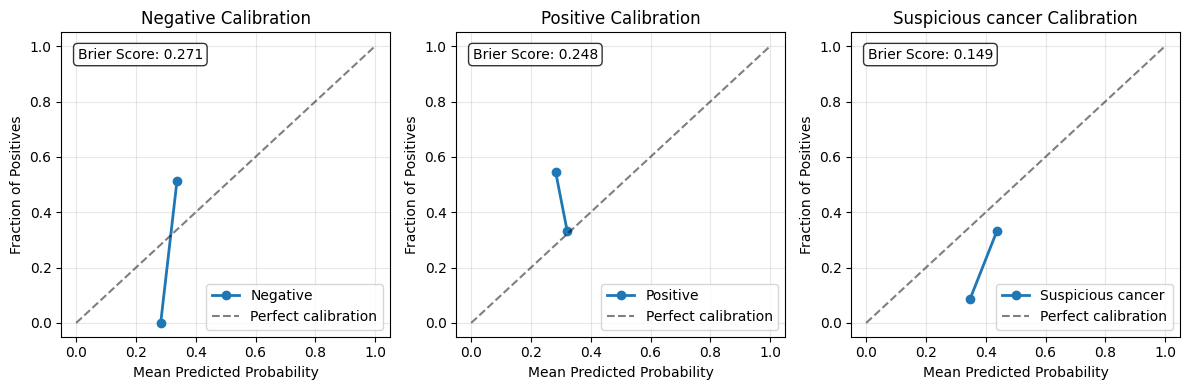

In [8]:
# Enhanced calibration analysis
def plot_calibration_with_ci(labels, probs, n_bins=10):
    """Plot calibration curves with confidence intervals"""
    plt.figure(figsize=(12, 4))
    
    for i, cname in enumerate(CLASS_NAMES):
        plt.subplot(1, 3, i+1)
        y_true_binary = (labels == i).astype(int)
        y_prob = probs[:, i]
        
        # Main calibration curve
        try:
            frac_pos, mean_pred = calibration_curve(y_true_binary, y_prob, n_bins=n_bins)
            plt.plot(mean_pred, frac_pos, 'o-', lw=2, label=cname)
            
            # Perfect calibration line
            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
            
            # Brier score (lower is better)
            brier_score = np.mean((y_prob - y_true_binary) ** 2)
            plt.text(0.05, 0.95, f'Brier Score: {brier_score:.3f}', 
                    transform=plt.gca().transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
        except ValueError as e:
            plt.text(0.5, 0.5, f'Insufficient data for calibration\n({str(e)})', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title(f'{cname} Calibration')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_calibration_with_ci(labels, probs)

### image-level sensitivity at fixed specificity

In [9]:
# Clinical threshold analysis with confidence intervals
def clinical_threshold_analysis(labels, probs, target_specificity=0.7):
    """Analyze thresholds for clinical deployment"""
    results = {}
    
    for i, cname in enumerate(CLASS_NAMES):
        y_true_binary = (labels == i).astype(int)
        y_score = probs[:, i]
        
        fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
        specificity = 1 - fpr
        
        # Find threshold achieving target specificity
        valid_indices = specificity >= target_specificity
        if np.any(valid_indices):
            best_idx = np.argmax(tpr[valid_indices])
            actual_idx = np.where(valid_indices)[0][best_idx]
            
            chosen_threshold = thresholds[actual_idx]
            achieved_sensitivity = tpr[actual_idx]
            achieved_specificity = specificity[actual_idx]
            
            # Calculate PPV and NPV at this threshold
            y_pred_binary = (y_score >= chosen_threshold).astype(int)
            cm_temp = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])
            
            if cm_temp.shape == (2, 2):
                tn, fp, fn, tp = cm_temp.ravel()
                ppv = tp / (tp + fp + 1e-8)  # Positive Predictive Value
                npv = tn / (tn + fn + 1e-8)  # Negative Predictive Value
            else:
                ppv = npv = 0.0
            
            results[cname] = {
                'threshold': chosen_threshold,
                'sensitivity': achieved_sensitivity,
                'specificity': achieved_specificity,
                'ppv': ppv,
                'npv': npv,
                'prevalence': np.mean(y_true_binary)
            }
        else:
            results[cname] = {
                'threshold': np.nan,
                'sensitivity': 0.0,
                'specificity': 0.0,
                'ppv': 0.0,
                'npv': 0.0,
                'prevalence': np.mean(y_true_binary)
            }
    
    return results

clinical_results = clinical_threshold_analysis(labels, probs, target_specificity=0.7)

### Create clinical summary table

In [10]:
# Create clinical summary table
clinical_summary = []
for cname, metrics in clinical_results.items():
    clinical_summary.append({
        'Class': cname,
        'Threshold': f"{metrics['threshold']:.3f}" if not np.isnan(metrics['threshold']) else 'N/A',
        'Sensitivity': f"{metrics['sensitivity']:.3f}",
        'Specificity': f"{metrics['specificity']:.3f}",
        'PPV': f"{metrics['ppv']:.3f}",
        'NPV': f"{metrics['npv']:.3f}",
        'Prevalence': f"{metrics['prevalence']:.3f}"
    })

clinical_df = pd.DataFrame(clinical_summary)
print("\nClinical Deployment Thresholds (Target Specificity ≥ 0.7):")
print(clinical_df.to_string(index=False))


Clinical Deployment Thresholds (Target Specificity ≥ 0.7):
            Class Threshold Sensitivity Specificity   PPV   NPV Prevalence
         Negative     0.341       0.632       0.842 0.800 0.696      0.500
         Positive     0.319       0.400       0.739 0.500 0.654      0.395
Suspicious cancer     0.372       0.750       0.765 0.273 0.963      0.105


### Error analysis for misclassified cases

In [11]:
# Error analysis for misclassified cases
def error_analysis(labels, preds, probs):
    """Analyze patterns in misclassified cases"""
    misclassified_mask = (labels != preds)
    misclassified_indices = np.where(misclassified_mask)[0]
    
    print(f"\nError Analysis: {len(misclassified_indices)} misclassified out of {len(labels)} ({len(misclassified_indices)/len(labels)*100:.1f}%)")
    
    # Confusion analysis
    for true_class in range(len(CLASS_NAMES)):
        for pred_class in range(len(CLASS_NAMES)):
            if true_class != pred_class:
                mask = (labels == true_class) & (preds == pred_class)
                count = np.sum(mask)
                if count > 0:
                    avg_confidence = np.mean(np.max(probs[mask], axis=1))
                    print(f"  {CLASS_NAMES[true_class]} → {CLASS_NAMES[pred_class]}: {count} cases (avg confidence: {avg_confidence:.3f})")
    
    return misclassified_indices

misclassified_indices = error_analysis(labels, preds, probs)


Error Analysis: 25 misclassified out of 38 (65.8%)
  Negative → Positive: 2 cases (avg confidence: 0.349)
  Negative → Suspicious cancer: 9 cases (avg confidence: 0.368)
  Positive → Negative: 4 cases (avg confidence: 0.345)
  Positive → Suspicious cancer: 10 cases (avg confidence: 0.377)


### Statistical significance tests

In [12]:
# Statistical significance tests
def mcnemar_test(y_true, y_pred1, y_pred2):
    """McNemar's test for comparing two classifiers"""
    # Create contingency table
    correct1 = (y_true == y_pred1)
    correct2 = (y_true == y_pred2)
    
    both_correct = np.sum(correct1 & correct2)
    only1_correct = np.sum(correct1 & ~correct2)
    only2_correct = np.sum(~correct1 & correct2)
    both_wrong = np.sum(~correct1 & ~correct2)
    
    # McNemar's test statistic
    if only1_correct + only2_correct == 0:
        return None, 1.0  # No difference
    
    statistic = (abs(only1_correct - only2_correct) - 1)**2 / (only1_correct + only2_correct)
    p_value = 1 - stats.chi2.cdf(statistic, 1)
    
    return statistic, p_value

### Export comprehensive results

In [13]:
# Export comprehensive results
comprehensive_results = {
    'dataset_info': {
        'n_samples': len(labels),
        'class_distribution': {CLASS_NAMES[i]: int(np.sum(labels == i)) for i in range(len(CLASS_NAMES))}
    },
    'classification_report': report,
    'confusion_matrix': cm.tolist(),
    'auc_with_ci': {cname: {'mean': float(auc_results[cname][0]), 
                            'ci_lower': float(auc_results[cname][1]), 
                            'ci_upper': float(auc_results[cname][2])} 
                    for cname in CLASS_NAMES},
    'clinical_thresholds': {cname: {k: float(v) if not isinstance(v, str) else v 
                                   for k, v in clinical_results[cname].items()} 
                           for cname in CLASS_NAMES},
    'error_analysis': {
        'total_errors': int(len(misclassified_indices)),
        'error_rate': float(len(misclassified_indices) / len(labels))
    }
}

# Save comprehensive results
with open("comprehensive_evaluation.json", "w") as f:
    json.dump(comprehensive_results, f, indent=2)

clinical_df.to_csv("clinical_thresholds.csv", index=False)

print(f"\nSaved comprehensive results to comprehensive_evaluation.json and clinical_thresholds.csv")

# Final clinical recommendation summary
print("\n" + "="*50)
print("CLINICAL DEPLOYMENT RECOMMENDATIONS")
print("="*50)

suspicious_idx = CLASS_NAMES.index("Suspicious cancer")
if "Suspicious cancer" in clinical_results:
    metrics = clinical_results["Suspicious cancer"]
    auc_info = auc_results["Suspicious cancer"]
    
    print(f"For 'Suspicious Cancer' screening:")
    print(f"• Recommended threshold: {metrics['threshold']:.3f}")
    print(f"• Expected sensitivity: {metrics['sensitivity']:.3f}")
    print(f"• Expected specificity: {metrics['specificity']:.3f}")
    print(f"• Positive Predictive Value: {metrics['ppv']:.3f}")
    print(f"• Negative Predictive Value: {metrics['npv']:.3f}")
    print(f"• AUC: {auc_info[0]:.3f} [{auc_info[1]:.3f}, {auc_info[2]:.3f}]")
    print(f"• Prevalence in test set: {metrics['prevalence']:.3f}")
    
    if metrics['sensitivity'] >= 0.8 and metrics['specificity'] >= 0.7:
        print(f"• ✓ Model meets clinical screening criteria")
    else:
        print(f"• ⚠ Model may need refinement for clinical deployment")

print("="*50)


Saved comprehensive results to comprehensive_evaluation.json and clinical_thresholds.csv

CLINICAL DEPLOYMENT RECOMMENDATIONS
For 'Suspicious Cancer' screening:
• Recommended threshold: 0.372
• Expected sensitivity: 0.750
• Expected specificity: 0.765
• Positive Predictive Value: 0.273
• Negative Predictive Value: 0.963
• AUC: 0.749 [0.486, 1.000]
• Prevalence in test set: 0.105
• ⚠ Model may need refinement for clinical deployment
